In [49]:
from causallib.estimation import StratifiedStandardization,MatchingIndividualOutcomeEstimator,IPW
from causallib.datasets import load_nhefs
from sklearn.linear_model import LinearRegression,LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
data = load_nhefs()
x,a,y = data.X,data.a,data.y

In [46]:
biny = (data.y > 0).astype(int)

In [52]:
estimators = [StratifiedStandardization(LinearRegression()),MatchingIndividualOutcomeEstimator(n_neighbors=3)]
for i in estimators:
    i.fit(x,a,biny)
d = dict(((idx,i.estimate_individual_outcome(x,a)) for idx,i in enumerate(estimators)))


In [63]:
mest = MatchingIndividualOutcomeEstimator(n_neighbors=3)
mest.fit(x,a,y)
mest.estimate_individual_outcome(x,a,predict_proba=False)

/home/micha/CausalInference/causallib/estimation/matching.py:635: UserWarning: You are attempting to classify outcomes which are non-integers. This is probably a mistake.
  outcome_from_matches = lambda x: self.matching.outcome_agg_function(self.matching.outcome_.loc[x])


,0,1
sample_id,,
0,-10.093960,10.434295
1,2.604970,0.457008
2,9.414486,14.857594
3,4.990117,-7.821247
4,4.989251,9.982066
...,...,...
1623,8.500028,-0.223271
1624,1.360117,2.384779
1625,3.514970,-2.723183


In [162]:
from sklearn.model_selection import train_test_split
xt,xv,at,av,yt,yv = train_test_split(x,a,y)
mest = MatchingIndividualOutcomeEstimator()
mest.fit(xt,at,yt)
ypredv = mest.estimate_individual_outcome(xv,av,yv)
ypredv_melt = ypredv.melt(var_name=at.name,value_name=yt.name)
trainval_match = pd.concat({"train":pd.concat([yt,at],axis=1),"val": ypredv_melt}).reset_index().rename(
    columns={"level_0":"fold","level_1":"sample_id"})
for gval,gidx in trainval_match.groupby(yt.name).groups.items():
    gx = trainval_match.loc[gidx]
    if len(gx[gx.fold=="val"])>1:
        if len(gx[gx.fold=="train"]) ==0:
            print(gx)

/home/micha/CausalInference/causallib/evaluation/evaluator.py:149: UserWarning: While evaluating msle: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  warnings.warn('While evaluating ' + metric_name + ': ' + str(v))
/home/micha/CausalInference/causallib/evaluation/evaluator.py:149: UserWarning: While evaluating msle: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  warnings.warn('While evaluating ' + metric_name + ': ' + str(v))
/home/micha/CausalInference/causallib/evaluation/evaluator.py:149: UserWarning: While evaluating msle: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  warnings.warn('While evaluating ' + metric_name + ': ' + str(v))
/home/micha/CausalInference/causallib/evaluation/evaluator.py:149: UserWarning: While evaluating msle: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  warnings.warn('While evaluating ' + metric_name +

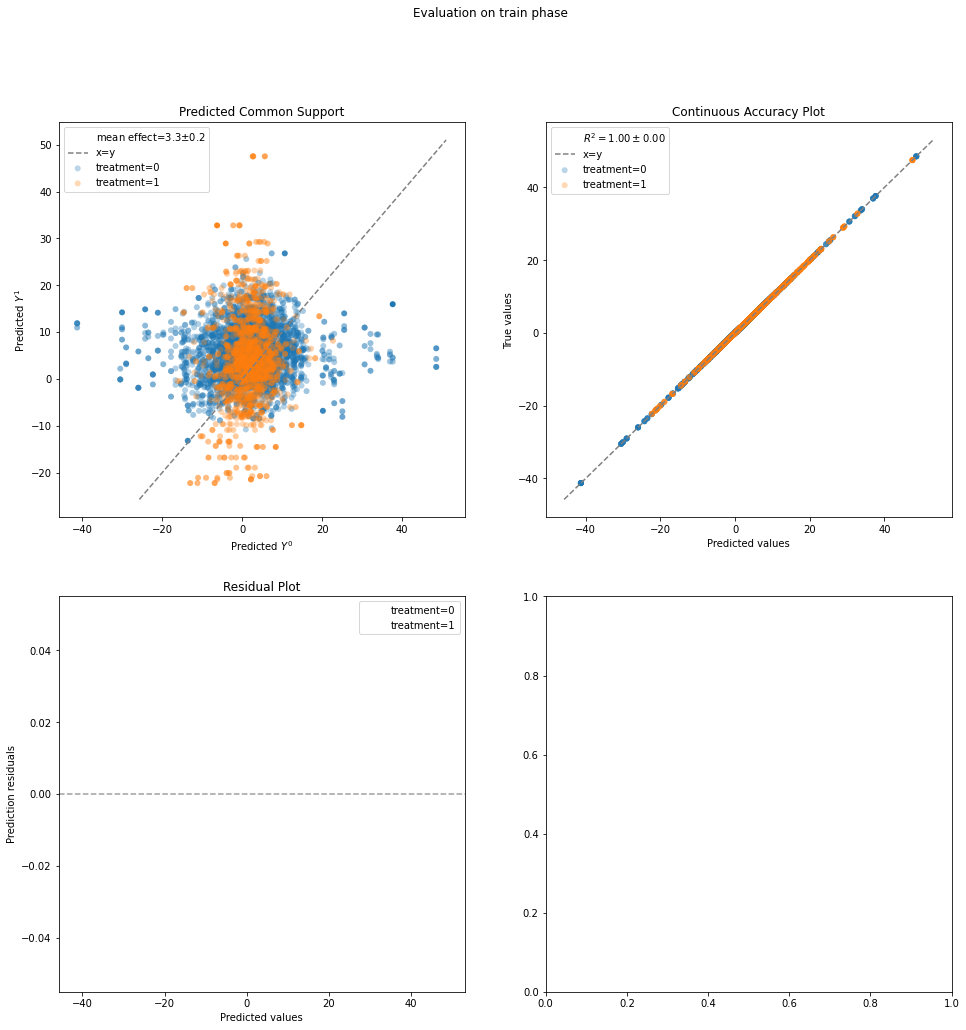

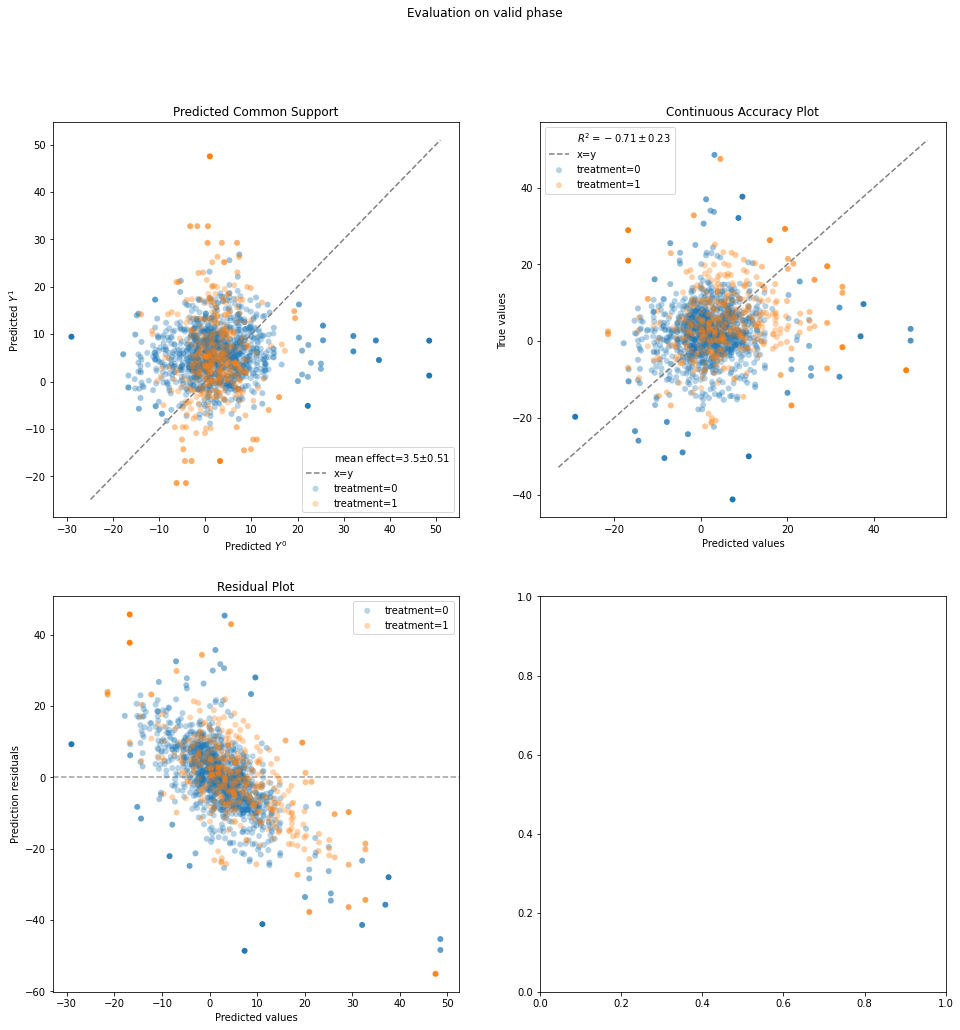

In [33]:
from causallib.evaluation import OutcomeEvaluator
plots=["common_support", "continuous_accuracy", "residuals"]
mest = MatchingIndividualOutcomeEstimator(n_neighbors=3)
mest.set_params(n_neighbors=3)
evaluator = OutcomeEvaluator(mest)
results = evaluator.evaluate_cv(data.X, data.a, data.y,
                                plots=plots)